# Ragone plot

This notebook shows how to generate a Ragone plot, based on the stack thickness and stack density. The procedure is from the "[rate-capability](https://github.com/pybamm-team/PyBaMM/blob/develop/docs/source/examples/notebooks/models/rate-capability.ipynb)" notebook - check out the many other [example notebooks](https://github.com/pybamm-team/PyBaMM/tree/develop/docs/source/examples/notebooks) from PyBaMM to estimate more cell metrics with simulations. At the end of the notebook, a scatterplot matrix is created that shows how stack energies vary with thickness, porosity and n/p ratio - with and without applied current.

In [1]:
# %pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
# !pip install git+https://github.com/pybamm-team/pybamm-tea.git # install PyBaMM-TEA if it is not installed
import pybamm
import pybamm_tea
import numpy as np
import matplotlib.pyplot as plt

_In this example we use the SPMe model with the default settings, but we could change it to other models, parameters, geometries... For example, you generate rate capability plots using the DFN model in [this script](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/scripts/rate_capability.py)._

Also we use the TEA class to relate the energy and power to the stack mass.

In [2]:
model = pybamm.lithium_ion.SPMe()

# set up the TEA class
input = {"Electrolyte density [kg.m-3]": 1276}
base = pybamm.ParameterValues("Chen2020")
tea_class = pybamm_tea.TEA(base, input)

C:\Users\Julian\Documents\GitHub\pybamm-tea\pybamm_tea\tea.py:187: UserWarning: 'Negative electrode active material density [kg.m-3]' and 'Negative electrode dry density [kg.m-3]' have been calculated from; 'Electrolyte density [kg.m-3]', 'Negative electrode porosity' and 'Negative electrode density [kg.m-3]'
  warnings.warn(
C:\Users\Julian\Documents\GitHub\pybamm-tea\pybamm_tea\tea.py:187: UserWarning: 'Positive electrode active material density [kg.m-3]' and 'Positive electrode dry density [kg.m-3]' have been calculated from; 'Electrolyte density [kg.m-3]', 'Positive electrode porosity' and 'Positive electrode density [kg.m-3]'
  warnings.warn(
C:\Users\Julian\Documents\GitHub\pybamm-tea\pybamm_tea\tea.py:430: UserWarning: 'Initial loss of lithium inventory' is set to 0.
  warnings.warn("'Initial loss of lithium inventory' is set to 0.")


_We now cycle a loop of different C-rates and run full discharge simulations for each C-rate. For each simulation we register the final discharge capacity, the applied current and the average discharge voltage. We can then generate the rate capability and the Ragone plots._

Gravimetric stack energy [W.h.kg-1]: 398.2646658914539
Gravimetric stack energy at C/20 [W.h.kg-1]: 396.6329412235033


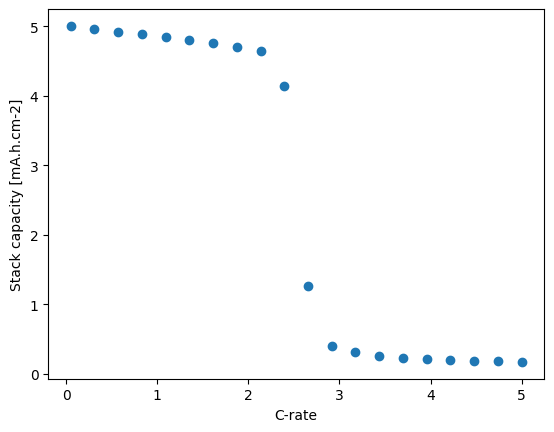

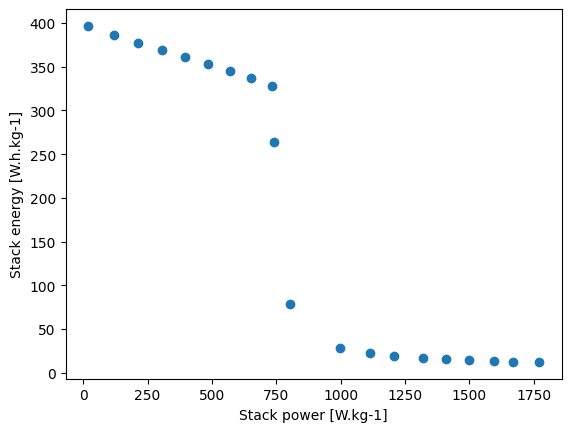

In [3]:
# set up the Ragone plot
C_rates = np.linspace(0.05, 5, 20)
capacities = np.zeros_like(C_rates)
currents = np.zeros_like(C_rates)
voltage_av = np.zeros_like(C_rates)

for i, C_rate in enumerate(C_rates):
    experiment = pybamm.Experiment(
        ["Discharge at {:.4f}C until 2.5V".format(C_rate)],
        period="{:.4f} seconds".format(10 / C_rate)
    )
    sim = pybamm.Simulation(
        model,
        experiment=experiment,
        solver=pybamm.CasadiSolver(dt_max=120),
        parameter_values=tea_class.parameter_values
    )
    sim.solve()

    time = sim.solution["Time [s]"].entries
    capacity = sim.solution["Discharge capacity [A.h]"]
    current = sim.solution["Current [A]"]
    voltage = sim.solution["Voltage [V]"]

    capacities[i] = capacity(time[-1])
    currents[i] = current(time[-1])
    voltage_av[i] = np.mean(voltage(time))

stack_thickness = tea_class.stack_energy["Stack thickness [m]"]
stack_density = tea_class.stack_energy["Stack density [kg.m-3]"]
stack_area = tea_class.parameter_values["Electrode height [m]"] * tea_class.parameter_values["Electrode width [m]"]

print("Gravimetric stack energy [W.h.kg-1]:", tea_class.stack_energy["Gravimetric stack energy [W.h.kg-1]"])
print("Gravimetric stack energy at C/20 [W.h.kg-1]:", capacities[0] * voltage_av[0] / stack_area / stack_thickness / stack_density)

plt.figure(1)
plt.scatter(C_rates, capacities / stack_area / 10) # 1000 mA.h.A.h-1 / 10000 cm2.m-2
plt.xlabel('C-rate')
plt.ylabel('Stack capacity [mA.h.cm-2]')

plt.figure(2)
plt.scatter(currents * voltage_av / stack_area / stack_thickness / stack_density, capacities * voltage_av / stack_area / stack_thickness / stack_density)
plt.xlabel('Stack power [W.kg-1]')
plt.ylabel('Stack energy [W.h.kg-1]')

plt.show()

### Thickness vs. porosity vs. n/p ratio scatterplot matrix

Without considering applied current, the energy density can _simply_ be increased by increasing thicknesses and decreasing porosities. The following matrix plot shows the usefulness of combining TEA classes with PyBaMM models to estimate dynamic limitations for the stack design arising with applied current.

Therefore, one can loop over parameter variations and create TEA classes and simulations with them. Essentially, the following equation is used to update the negative electrode thickness:

\begin{equation*}
t^{-}=\frac{n / p_{\text {theoretical }} C_{\text {max }}^{+} v_{\text {active }}^{+} t^{+}}{C_{\text {max }}^{-} v_{\text {active }}^{-}}
\end{equation*}

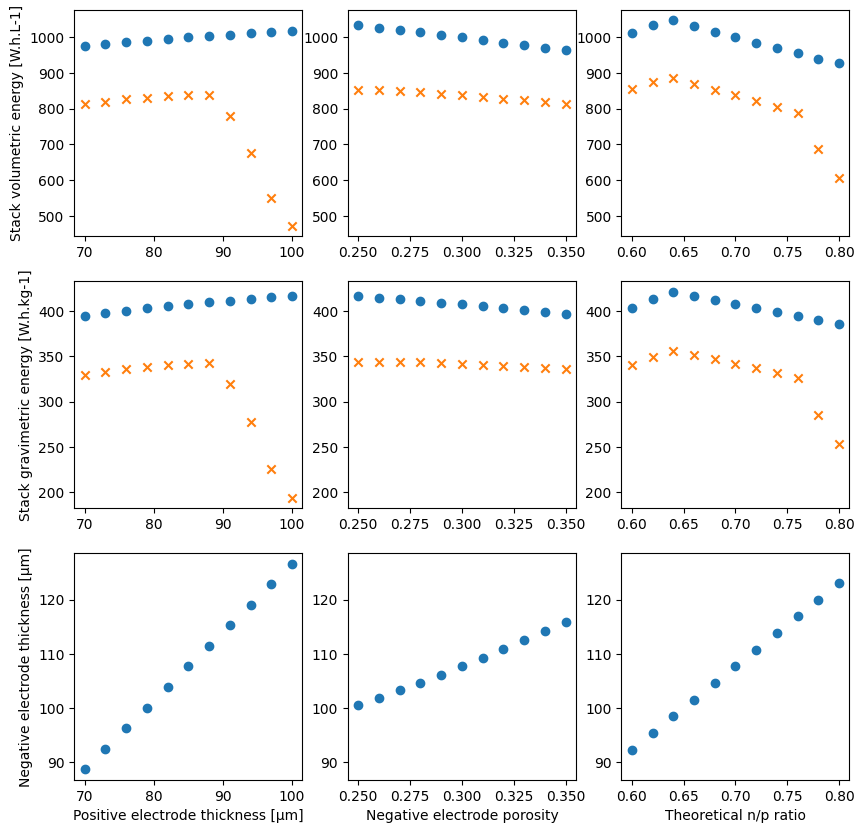

In [5]:
C_rate = 2
experiment = pybamm.Experiment(
        ["Discharge at {:.4f}C until 2.5V".format(C_rate)],
        period="{:.4f} seconds".format(10 / C_rate)
    )

# initialize the fix theoretical n/p ratio for the thickness calculation
input["Theoretical n/p ratio"] = 0.7
input["Positive electrode thickness [m]"] = 85e-6
input["Negative electrode porosity"] = 0.3
input["Negative electrode active material volume fraction"] = 1 - input["Negative electrode porosity"] # special case, not necessary as input if inactive materials are included

# initialize the active material concentrations to the zero in the negative electrode and to the maximum in the positive electrode
input["Initial concentration in negative electrode [mol.m-3]"] = 0
input["Initial concentration in positive electrode [mol.m-3]"] = tea_class.parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
                                                                  # * tea_class.stack_energy.get("Initial lithium inventory / positive electrode theoretical capacity")
input["Initial loss of lithium inventory"] = 0.1 # 10% loss of lithium inventory

# generate an array's of thicknesses and n/p ratios to loop over
pe_thicknesses = np.linspace(70e-6, 100e-6, 11)
ne_porosities = np.linspace(0.25, 0.35, 11)
th_n_p_ratios = np.linspace(0.6, 0.8, 11)

# initialize lists for the stack energy densities
stack_volumetric_energy_thickness = []
stack_gravimetric_energy_thickness = []
stack_volumetric_energy_porosity = []
stack_gravimetric_energy_porosity = []
stack_volumetric_energy_n_p = []
stack_gravimetric_energy_n_p = []
stack_volumetric_energy_c_thickness = []
stack_gravimetric_energy_c_thickness = []
stack_volumetric_energy_c_porosity = []
stack_gravimetric_energy_c_porosity = []
stack_volumetric_energy_c_n_p = []
stack_gravimetric_energy_c_n_p = []
ne_thickness_thickness = []
ne_thickness_porosity = []
ne_thickness_n_p = []

# loop over the thicknesses and calculate the stack energy densities
for thickness in pe_thicknesses:
    # update the positive electrode thickness in the input
    input.update({"Positive electrode thickness [m]": thickness})
    
    # create a TEA class with the updated input
    tea_class = pybamm_tea.TEA(base, input)

    # save the calculated stack energy densities in the lists
    stack_volumetric_energy_thickness.append(tea_class.stack_energy.get("Volumetric stack energy [W.h.L-1]"))
    stack_gravimetric_energy_thickness.append(tea_class.stack_energy.get("Gravimetric stack energy [W.h.kg-1]"))
    ne_thickness_thickness.append(tea_class.parameter_values.get("Negative electrode thickness [m]"))
    
    # create simulation
    sim = pybamm.Simulation(
        model,
        experiment=experiment,
        solver=pybamm.CasadiSolver(dt_max=120),
        parameter_values=tea_class.parameter_values
    )
    sim.solve()

    # calculate the stack energy densities from the simulation and save them in the lists
    time = sim.solution["Time [s]"].entries
    capacity = sim.solution["Discharge capacity [A.h]"]
    voltage = sim.solution["Voltage [V]"]

    capacity = capacity(time[-1])
    voltage_av = np.mean(voltage(time))
    
    stack_thickness = tea_class.stack_energy["Stack thickness [m]"]
    stack_density = tea_class.stack_energy["Stack density [kg.m-3]"]
    stack_area = tea_class.parameter_values["Electrode height [m]"] * tea_class.parameter_values["Electrode width [m]"]
    
    stack_volumetric_energy_c_thickness.append(capacity * voltage_av / stack_area / stack_thickness / 1000)
    stack_gravimetric_energy_c_thickness.append(capacity * voltage_av / stack_area / stack_thickness / stack_density)

# initialize the positive electrode thickness to calculate the negative electrode thickness based on the theoretical n/p ratio
input["Positive electrode thickness [m]"] = 85e-6
# loop over the porosities and calculate the stack energy densities
for porosity in ne_porosities:
    # update the negative electrode porosity in the input
    input.update({"Negative electrode porosity": porosity})
    input.update({"Negative electrode active material volume fraction": 1 - porosity}) # special case, not necassary if inactive materials are included
    
    # create a TEA class with the updated input
    tea_class = pybamm_tea.TEA(base, input)

    # save the calculated stack energy densities in the lists
    stack_volumetric_energy_porosity.append(tea_class.stack_energy.get("Volumetric stack energy [W.h.L-1]"))
    stack_gravimetric_energy_porosity.append(tea_class.stack_energy.get("Gravimetric stack energy [W.h.kg-1]"))
    ne_thickness_porosity.append(tea_class.parameter_values.get("Negative electrode thickness [m]"))
    
    # create simulation
    sim = pybamm.Simulation(
        model,
        experiment=experiment,
        solver=pybamm.CasadiSolver(dt_max=120),
        parameter_values=tea_class.parameter_values
    )
    sim.solve()

    # calculate the stack energy densities from the simulation and save them in the lists
    time = sim.solution["Time [s]"].entries
    capacity = sim.solution["Discharge capacity [A.h]"]
    voltage = sim.solution["Voltage [V]"]

    capacity = capacity(time[-1])
    voltage_av = np.mean(voltage(time))
    
    stack_thickness = tea_class.stack_energy["Stack thickness [m]"]
    stack_density = tea_class.stack_energy["Stack density [kg.m-3]"]
    stack_area = tea_class.parameter_values["Electrode height [m]"] * tea_class.parameter_values["Electrode width [m]"]
    
    stack_volumetric_energy_c_porosity.append(capacity * voltage_av / stack_area / stack_thickness / 1000)
    stack_gravimetric_energy_c_porosity.append(capacity * voltage_av / stack_area / stack_thickness / stack_density)

# initialize the porosity
input["Negative electrode porosity"] = 0.3
input["Negative electrode active material volume fraction"] = 1 - input["Negative electrode porosity"] # special case, not necassary if inactive materials are included
# loop over the theoretical n/p ratios and calculate the stack energy densities
for th_n_p_ratio in th_n_p_ratios:
    # update the positive electrode thickness in the input
    input.update({"Theoretical n/p ratio": th_n_p_ratio})
    
    # create a TEA class with the updated input
    tea_class = pybamm_tea.TEA(base, input)

    # save the calculated stack energy densities in the lists
    stack_volumetric_energy_n_p.append(tea_class.stack_energy.get("Volumetric stack energy [W.h.L-1]"))
    stack_gravimetric_energy_n_p.append(tea_class.stack_energy.get("Gravimetric stack energy [W.h.kg-1]"))
    ne_thickness_n_p.append(tea_class.parameter_values.get("Negative electrode thickness [m]"))
    
    # create simulation
    sim = pybamm.Simulation(
        model,
        experiment=experiment,
        solver=pybamm.CasadiSolver(dt_max=120),
        parameter_values=tea_class.parameter_values
    )
    sim.solve()

    # calculate the stack energy densities from the simulation and save them in the lists
    time = sim.solution["Time [s]"].entries
    capacity = sim.solution["Discharge capacity [A.h]"]
    voltage = sim.solution["Voltage [V]"]

    capacity = capacity(time[-1])
    voltage_av = np.mean(voltage(time))
    
    stack_thickness = tea_class.stack_energy["Stack thickness [m]"]
    stack_density = tea_class.stack_energy["Stack density [kg.m-3]"]
    stack_area = tea_class.parameter_values["Electrode height [m]"] * tea_class.parameter_values["Electrode width [m]"]
    
    stack_volumetric_energy_c_n_p.append(capacity * voltage_av / stack_area / stack_thickness / 1000)
    stack_gravimetric_energy_c_n_p.append(capacity * voltage_av / stack_area / stack_thickness / stack_density)    

# create a figure with 9 subplots
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10, 10))

# plot stack energy vs negative electrode thickness
ax1.scatter(pe_thicknesses * 1e6, stack_volumetric_energy_thickness, marker="o")
ax1.scatter(pe_thicknesses * 1e6, stack_volumetric_energy_c_thickness, marker="x")
ax1.set_ylabel("Stack volumetric energy [W.h.L-1]")
ax4.scatter(pe_thicknesses * 1e6, stack_gravimetric_energy_thickness, marker="o")
ax4.scatter(pe_thicknesses * 1e6, stack_gravimetric_energy_c_thickness, marker="x")
ax4.set_ylabel("Stack gravimetric energy [W.h.kg-1]")
ax7.scatter(pe_thicknesses * 1e6, [x * 1e6 for x in ne_thickness_thickness])
ax7.set_ylabel("Negative electrode thickness [µm]")
ax7.set_xlabel("Positive electrode thickness [µm]")
# plot stack energy vs negative electrode porosity
ax2.scatter(ne_porosities, stack_volumetric_energy_porosity, marker="o")
ax2.scatter(ne_porosities, stack_volumetric_energy_c_porosity, marker="x")
ax5.scatter(ne_porosities, stack_gravimetric_energy_porosity, marker="o")
ax5.scatter(ne_porosities, stack_gravimetric_energy_c_porosity, marker="x")
ax8.scatter(ne_porosities, [x * 1e6 for x in ne_thickness_porosity])
ax8.set_xlabel("Negative electrode porosity")
# plot stack energy vs theoretical n/p ratio
ax3.scatter(th_n_p_ratios, stack_volumetric_energy_n_p, marker="o")
ax3.scatter(th_n_p_ratios, stack_volumetric_energy_c_n_p, marker="x")
ax6.scatter(th_n_p_ratios, stack_gravimetric_energy_n_p, marker="o")
ax6.scatter(th_n_p_ratios, stack_gravimetric_energy_c_n_p, marker="x")
ax9.scatter(th_n_p_ratios, [x * 1e6 for x in ne_thickness_n_p], label="ne thickness")
ax9.set_xlabel("Theoretical n/p ratio")

# set the y-axis limits for ax1, ax2, and ax3
row1_y_min = min(min(stack_volumetric_energy_c_thickness), min(stack_volumetric_energy_c_porosity), min(stack_volumetric_energy_c_n_p))
row1_y_max = max(max(stack_volumetric_energy_thickness), max(stack_volumetric_energy_porosity), max(stack_volumetric_energy_n_p))
row1_range = row1_y_max - row1_y_min
ax1.set_ylim(row1_y_min - 0.05 * row1_range, row1_y_max + 0.05 * row1_range)
ax2.set_ylim(row1_y_min - 0.05 * row1_range, row1_y_max + 0.05 * row1_range)
ax3.set_ylim(row1_y_min - 0.05 * row1_range, row1_y_max + 0.05 * row1_range)
# set the y-axis limits for ax4, ax5, and ax6
row2_y_min = min(min(stack_gravimetric_energy_c_thickness), min(stack_gravimetric_energy_c_porosity), min(stack_gravimetric_energy_c_n_p))
row2_y_max = max(max(stack_gravimetric_energy_thickness), max(stack_gravimetric_energy_porosity), max(stack_gravimetric_energy_n_p))
row2_range = row2_y_max - row2_y_min
ax4.set_ylim(row2_y_min - 0.05 * row2_range, row2_y_max + 0.05 * row2_range)
ax5.set_ylim(row2_y_min - 0.05 * row2_range, row2_y_max + 0.05 * row2_range)
ax6.set_ylim(row2_y_min - 0.05 * row2_range, row2_y_max + 0.05 * row2_range)
# set the y-axis limits for ax7, ax8, and ax9
row3_y_min = min(min([x * 1e6 for x in ne_thickness_thickness]), min([x * 1e6 for x in ne_thickness_porosity]), min([x * 1e6 for x in ne_thickness_n_p]))
row3_y_max = max(max([x * 1e6 for x in ne_thickness_thickness]), max([x * 1e6 for x in ne_thickness_porosity]), max([x * 1e6 for x in ne_thickness_n_p]))
row3_range = row3_y_max - row3_y_min
ax7.set_ylim(row3_y_min - 0.05 * row3_range, row3_y_max + 0.05 * row3_range)
ax8.set_ylim(row3_y_min - 0.05 * row3_range, row3_y_max + 0.05 * row3_range)
ax9.set_ylim(row3_y_min - 0.05 * row3_range, row3_y_max + 0.05 * row3_range)

# show the plot
plt.show()